In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms, utils
import numpy as np
import scipy.misc
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import json
from PIL import Image
import cv2
import os


In [2]:
def to_grayscale(image):
    
    image = torch.sum(image, dim=0)
    image = torch.div(image, image.shape[0])
    return image

In [3]:
def image_preprocess(image):
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    normalize = transforms.Normalize(mean,std)
    preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
    ])
    temp=preprocess(image).unsqueeze(0)
    image = Variable(temp.cuda())
    return image



def image_detouch(image):
  image = image.squeeze()
  print("checkpoiny")

  newimage = image.transpose(0,1)
  newimage = newimage.transpose(1,2)
  newimage=image_deprocess(newimage)
  return newimage
 

def image_deprocess(image):
    
    image=image * torch.Tensor([0.229, 0.224, 0.225]).cuda()  
    image=image + torch.Tensor([0.485, 0.456, 0.406]).cuda()
    return image

def load_image(path):
    image = Image.open(path)
    plt.imshow(image)
    plt.title("Image loaded successfully")
    return image
def predict(image):
    outputs = vgg(image)
    outputs = nn.functional.softmax(outputs, dim = 1)
    n, prediction = torch.max(outputs.data, 1)
    index = prediction[0].item()
    prob = outputs.tolist()[0]
    return index,prob

In [5]:
labels = json.load(open('imagenet_class_index.json'))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
vgg = models.vgg16(pretrained=True)

vgg=vgg.to('cuda')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 300MB/s]


In [7]:
def plot_weight(filters,weight,layer,k,kp):
  fig = plt.figure()
  plt.rcParams["figure.figsize"] = (10, 10)
  # filters= filters.cpu().detach().numpy()
  i=0
  while i<kp:
    a = fig.add_subplot(k,k,i+1)
    imgplot = plt.imshow(filters[i].cpu())
    plt.axis('off')
    i=i+1
def visualize_weights(image, layer):
    weight= []
    for i in vgg.features.children():
        if isinstance(i, torch.nn.modules.conv.Conv2d):
            w=i.weight.data
            weight.append(w)
    return weight
def visualize_filter(weight,layer):
    fil = []
    for i in range(weight[layer].shape[0]):
        fil.append(weight[layer][i,:,:,:].sum(dim=0))
        fil[i].div(weight[layer].shape[1])
    return fil
    

8


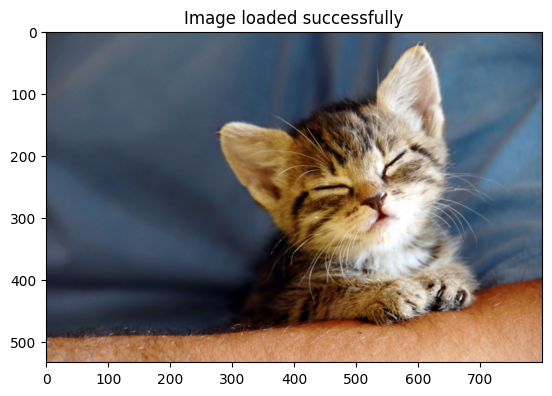

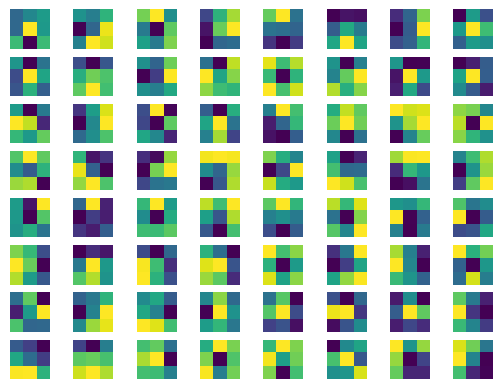

In [8]:
sample_image= load_image("kitten_1.jpg")


sample_image = image_preprocess(sample_image)
x,y=predict(sample_image)
weight=visualize_weights(sample_image, 0)
filters=visualize_filter(weight,0)
k=int(np.sqrt(weight[0].shape[0]))
print(k)
plot_weight(filters,weight,0,k,k*k)


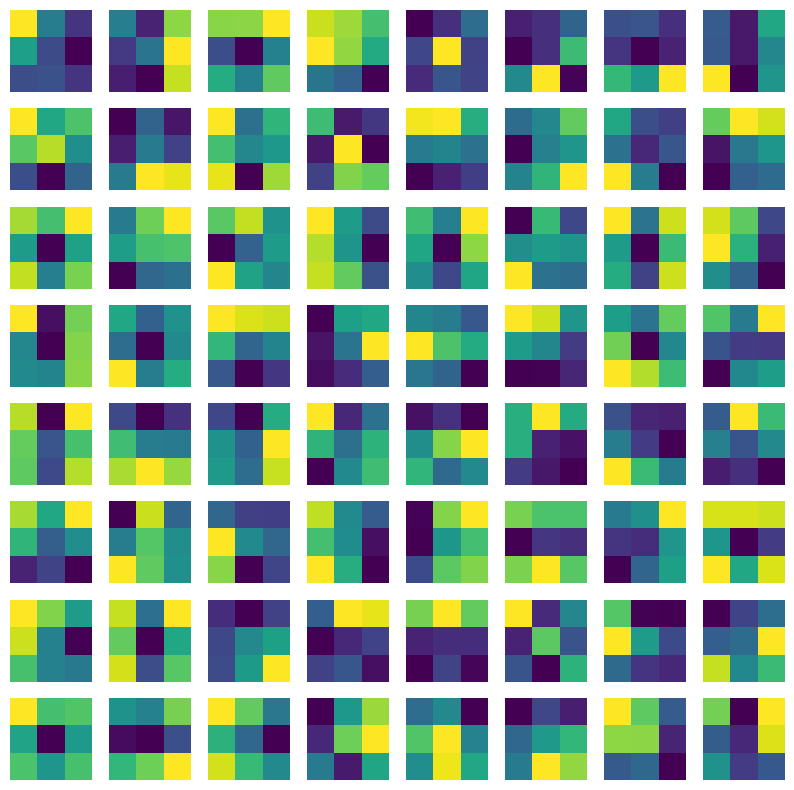

In [10]:
weight=visualize_weights(sample_image, 1)
filters=visualize_filter(weight,1)
k=int(np.sqrt(weight[1].shape[0]))
plot_weight(filters,weight,1,k,k*k)


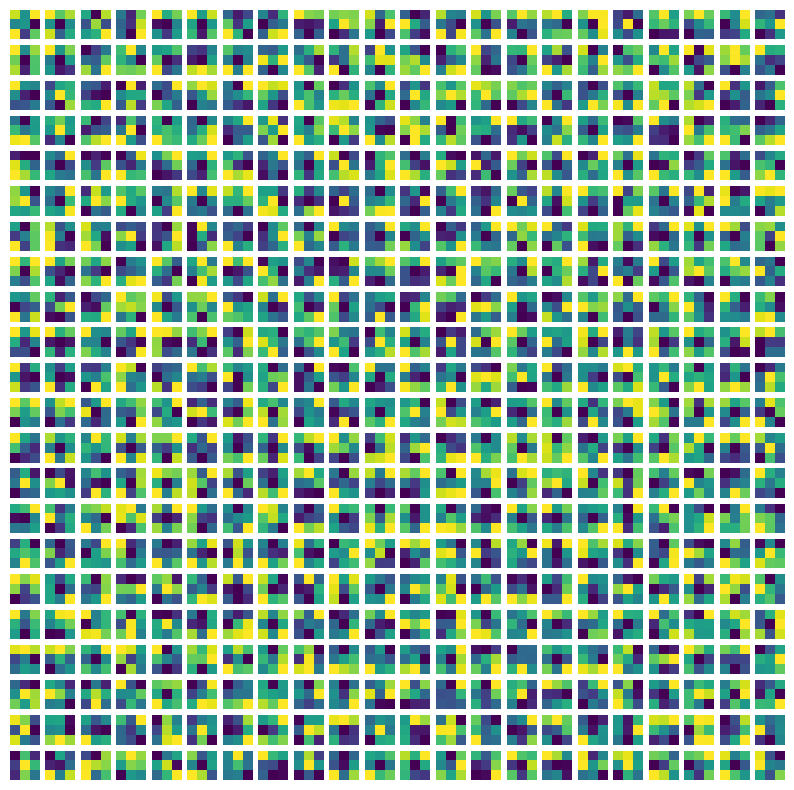

In [ ]:
weight=visualize_weights(sample_image, -1)
filters=visualize_filter(weight,-1)
k=int(np.sqrt(weight[-1].shape[0]))
plot_weight(filters,weight,-1,k,k*k)


In [ ]:
modulelist = list(vgg.features.modules())


In [11]:
def plot_image(image,heatmap):

  updated_image=image_detouch(image)
  updated_image= updated_image.cpu().detach().numpy()
  fig = plt.figure()

  plt.rcParams["figure.figsize"] = (20, 20)
  print("hi")
  a = fig.add_subplot(1,2,1)
  imgplot = plt.imshow(updated_image)
  plt.title('Original Image')
  plt.axis('off') 

  a = fig.add_subplot(1,2,2)
  imgplot = plt.imshow(heatmap)
  plt.title('Heatmap')
  plt.axis('off') 


def heatmapFun(model, image, label, oSize = 10, stride = 10, occ_pixel = 0.5):
    n = int(np.ceil((image.shape[-1]-oSize)/stride))
    m = int(np.ceil((image.shape[-2]-oSize)/stride))
    heatmap = torch.zeros((n, m)) 
    i=0
    j=0
    
    while i<n:
        for j in range(m): 
            h= i*stride
            w = j*stride
            if(h+oSize>=image.shape[-1] or w+oSize>=image.shape[-2]):
              continue
            
            input_image = image.clone().detach()
            input_image[:, :, w:(w+oSize), h:(h+oSize)] = occ_pixel
            _,data=predict(input_image)
            prob = data[label]
            heatmap[i, j] = prob 
        i=i+1
    
    return heatmap


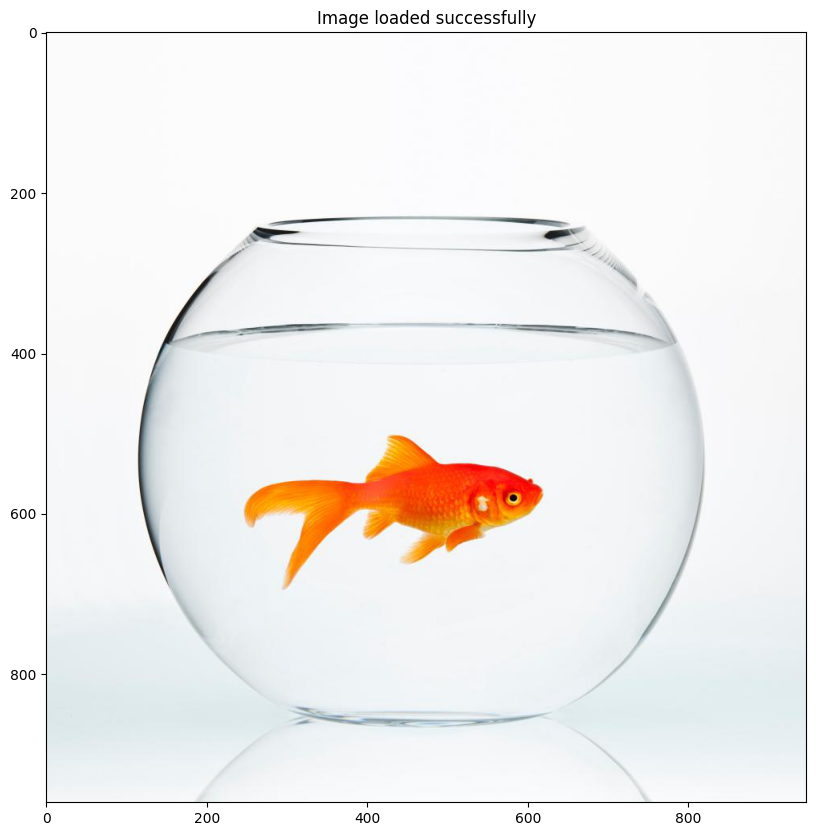

In [13]:
sample_image= load_image("goldfish.jpg")


In [14]:

sample_image = image_preprocess(sample_image)


In [15]:
ind,_=predict(sample_image)
print(ind)

1


In [16]:
heatmap = heatmapFun(vgg,sample_image, ind, 16, 8)

checkpoiny
hi


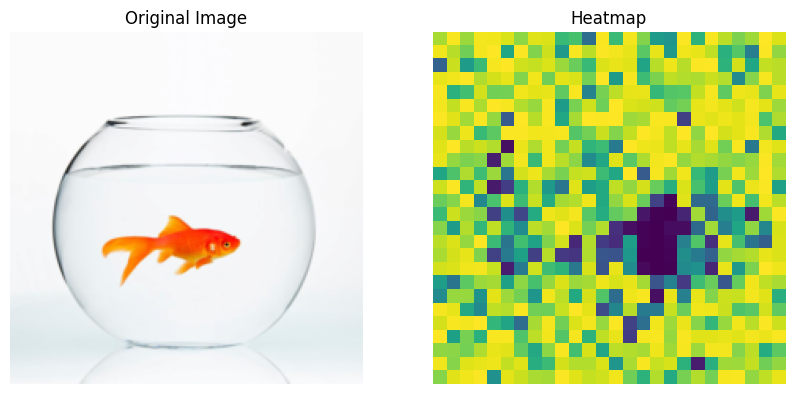

In [17]:
plot_image(sample_image,heatmap)

In [18]:
normalise = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalise
    ])

In [19]:
def image_preprocess_for_sal(image):
  mean=[0.485, 0.456, 0.406]
  std=[0.229, 0.224, 0.225]
  normalize = transforms.Normalize(mean,std)
  preprocess = transforms.Compose([
  transforms.Resize((224,224)),
  transforms.ToTensor(),
  normalize
  ])
  image=preprocess(image).unsqueeze(0)
  # image = Variable(temp.cuda())
  return image

def saliencyMapFun(image, label):
    image=image_preprocess(image)
    
    image = Variable(image.cuda(), requires_grad=True)
    print(image)
    output = vgg.forward(image)
    output[0][label].backward()
    grads = image.grad.data.clamp(min=0)
    grads.squeeze_()
    grads.transpose_(0,1)
    grads.transpose_(1,2)
    grads = np.amax(grads.cpu().numpy(), axis=2)
    
    
    return grads

387


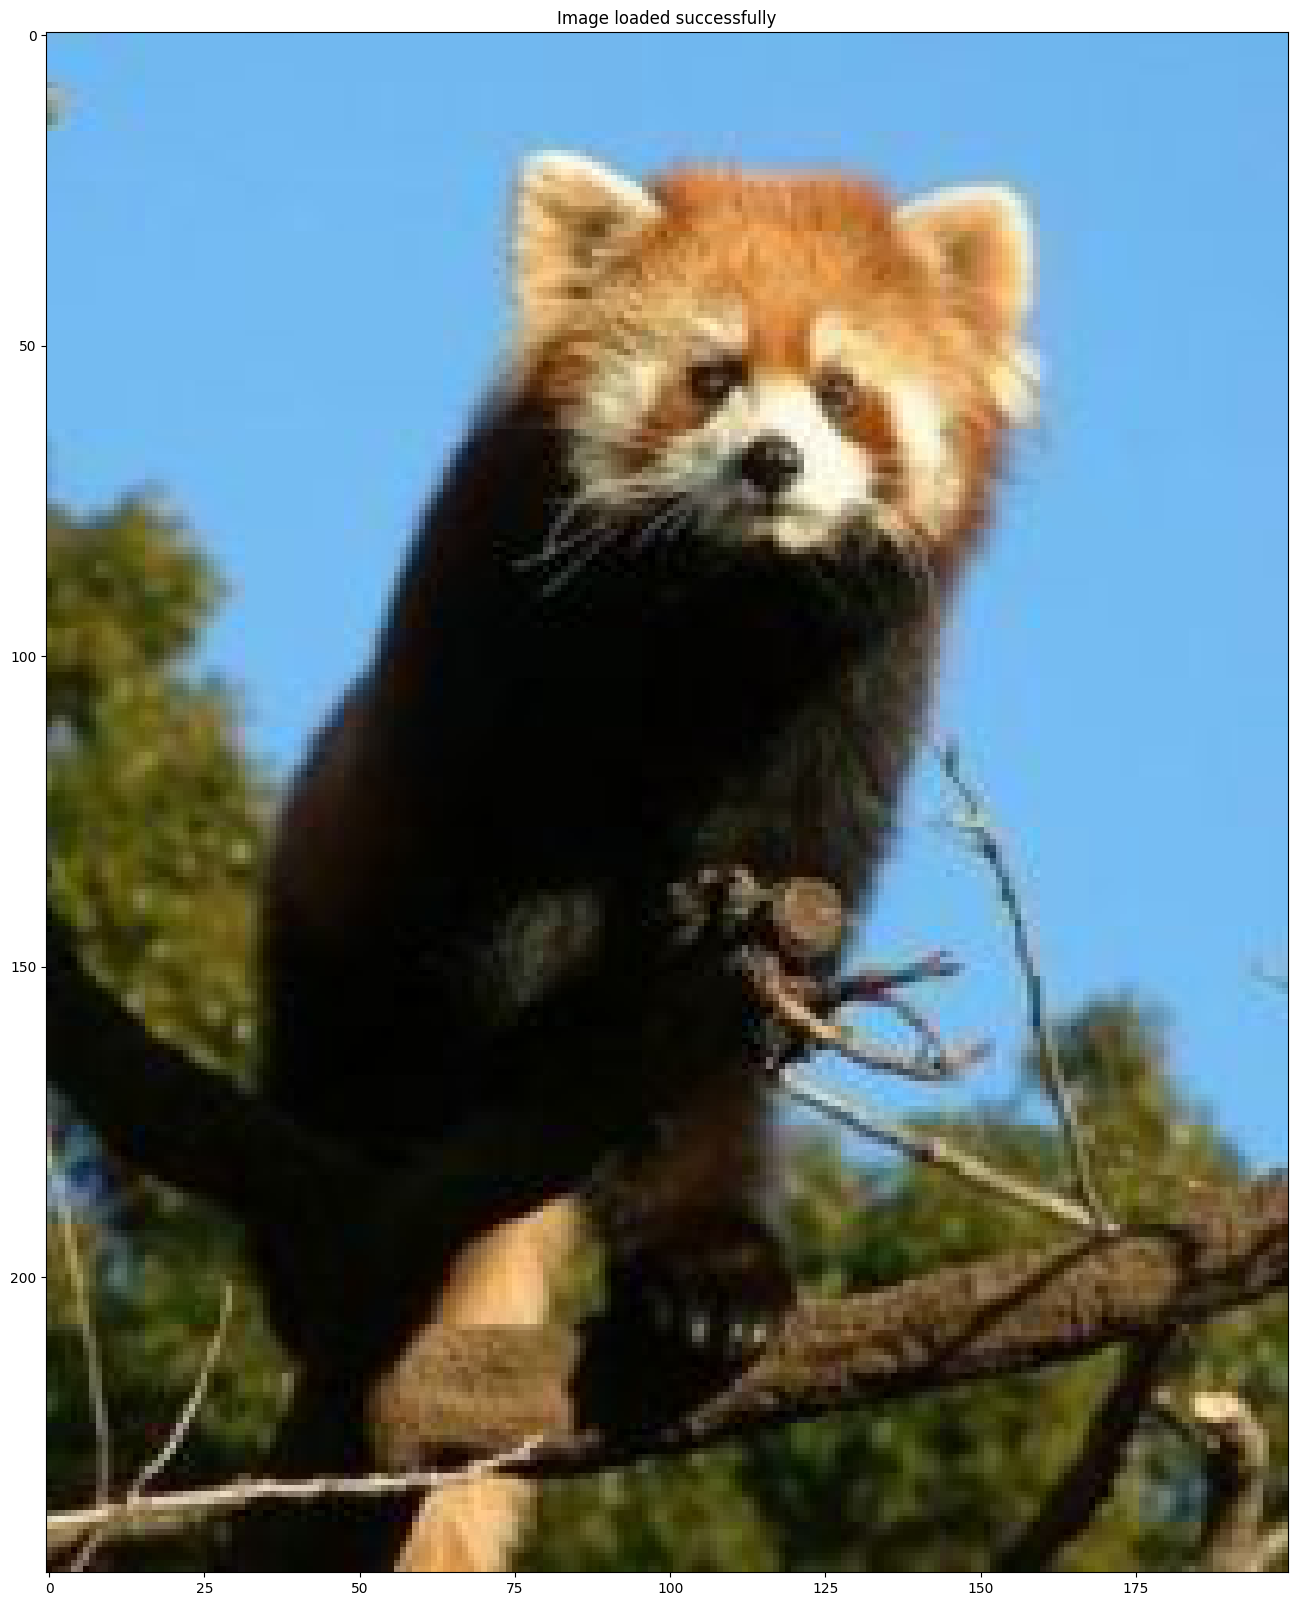

In [20]:
imgx=load_image('bhalluk.jpg')
imgx=image_preprocess(imgx)

ind,_=predict(imgx)
print(ind)


tensor([[[[-0.0458, -0.0629, -0.0801,  ..., -0.2684, -0.2684, -0.2684],
          [-0.0972, -0.1314, -0.1486,  ..., -0.2684, -0.2684, -0.2684],
          [-0.1828, -0.1999, -0.2342,  ..., -0.2513, -0.2513, -0.2513],
          ...,
          [-0.8164, -1.1075, -1.3815,  ...,  0.2282, -0.1999, -0.5767],
          [-1.3815, -1.5014, -1.5870,  ..., -0.3883, -0.6794, -1.0048],
          [-1.6384, -1.3987, -1.2274,  ..., -0.6794, -0.6965, -0.9363]],

         [[ 1.1331,  1.1506,  1.1681,  ...,  1.1331,  1.1331,  1.1331],
          [ 1.1506,  1.1681,  1.1856,  ...,  1.1331,  1.1331,  1.1331],
          [ 1.1681,  1.1856,  1.2031,  ...,  1.1155,  1.1155,  1.1155],
          ...,
          [-1.0378, -1.3354, -1.6155,  ...,  0.1001, -0.3025, -0.6527],
          [-1.6155, -1.7206, -1.8256,  ..., -0.5301, -0.7752, -1.0903],
          [-1.8606, -1.6155, -1.4405,  ..., -0.8277, -0.7927, -1.0203]],

         [[ 2.2391,  2.2391,  2.1868,  ...,  2.3088,  2.3088,  2.3088],
          [ 2.3263,  2.3263,  

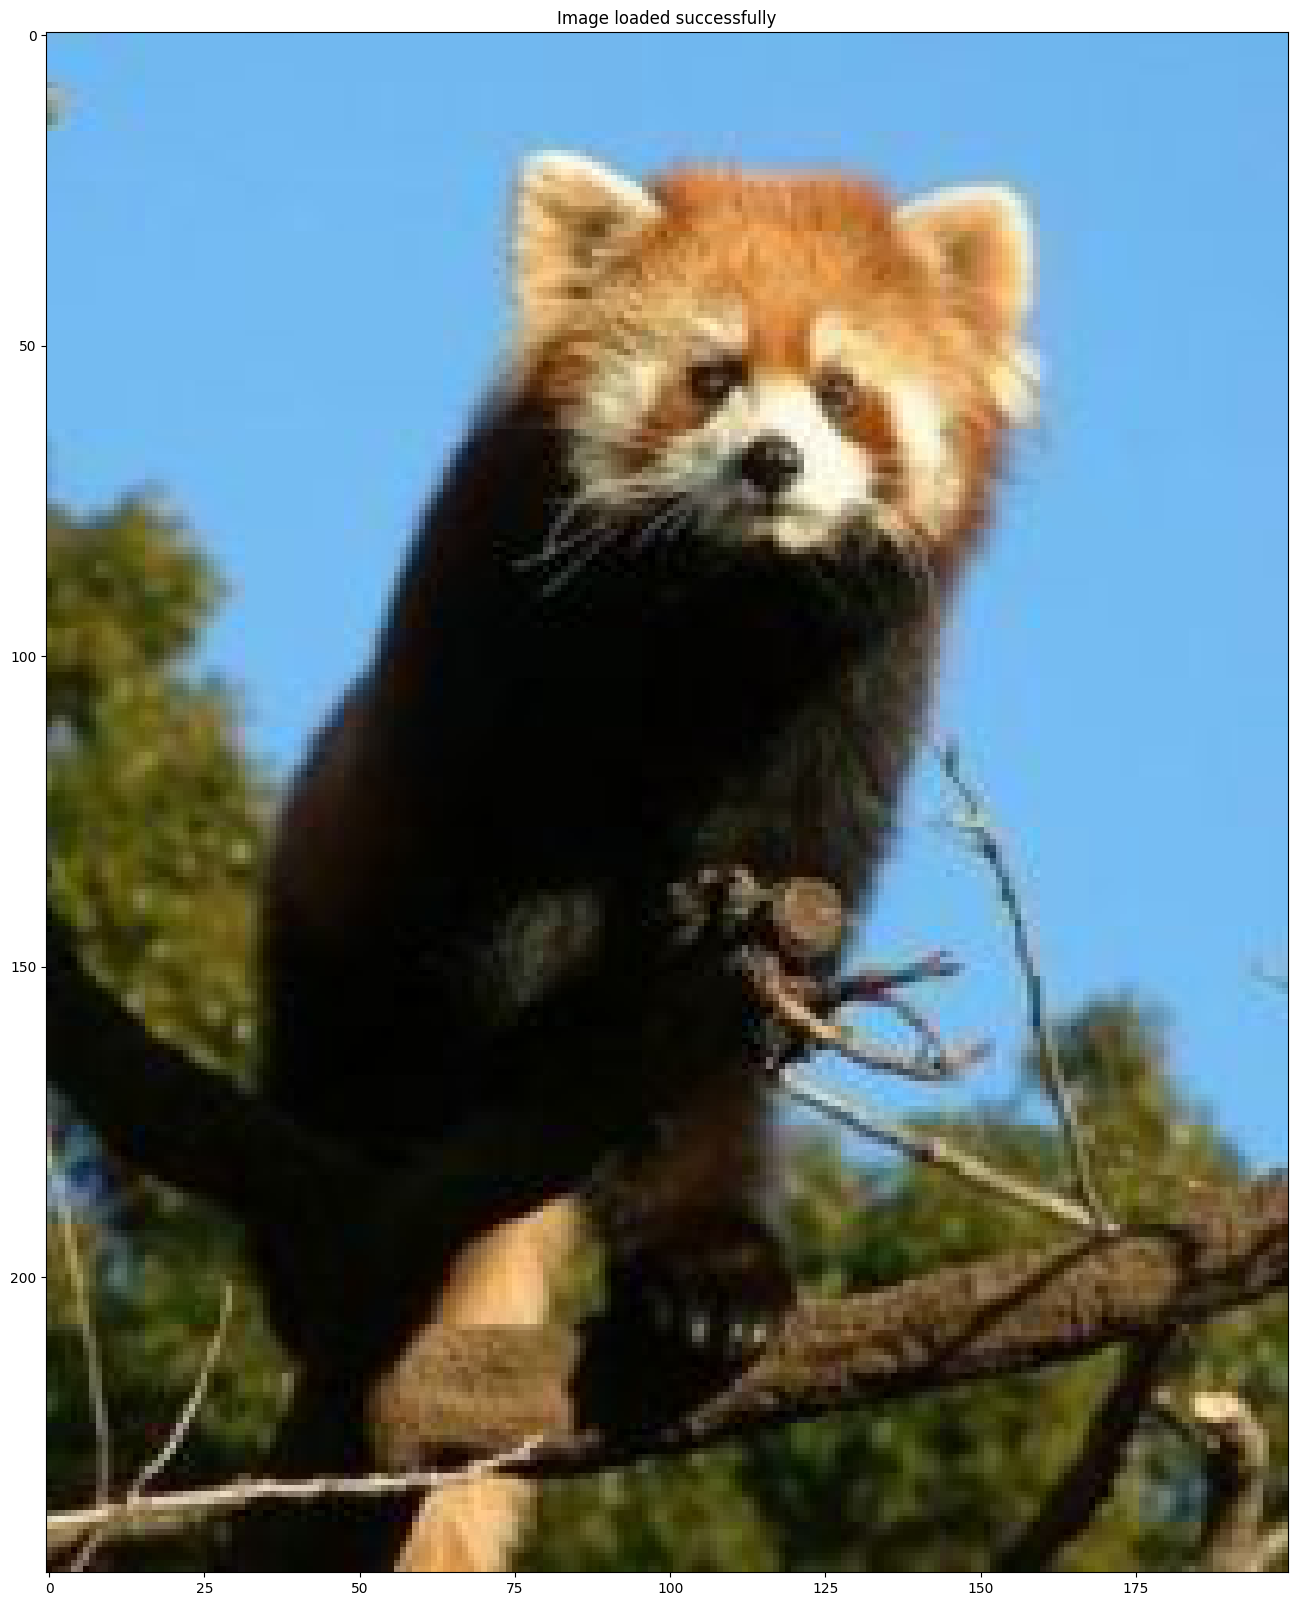

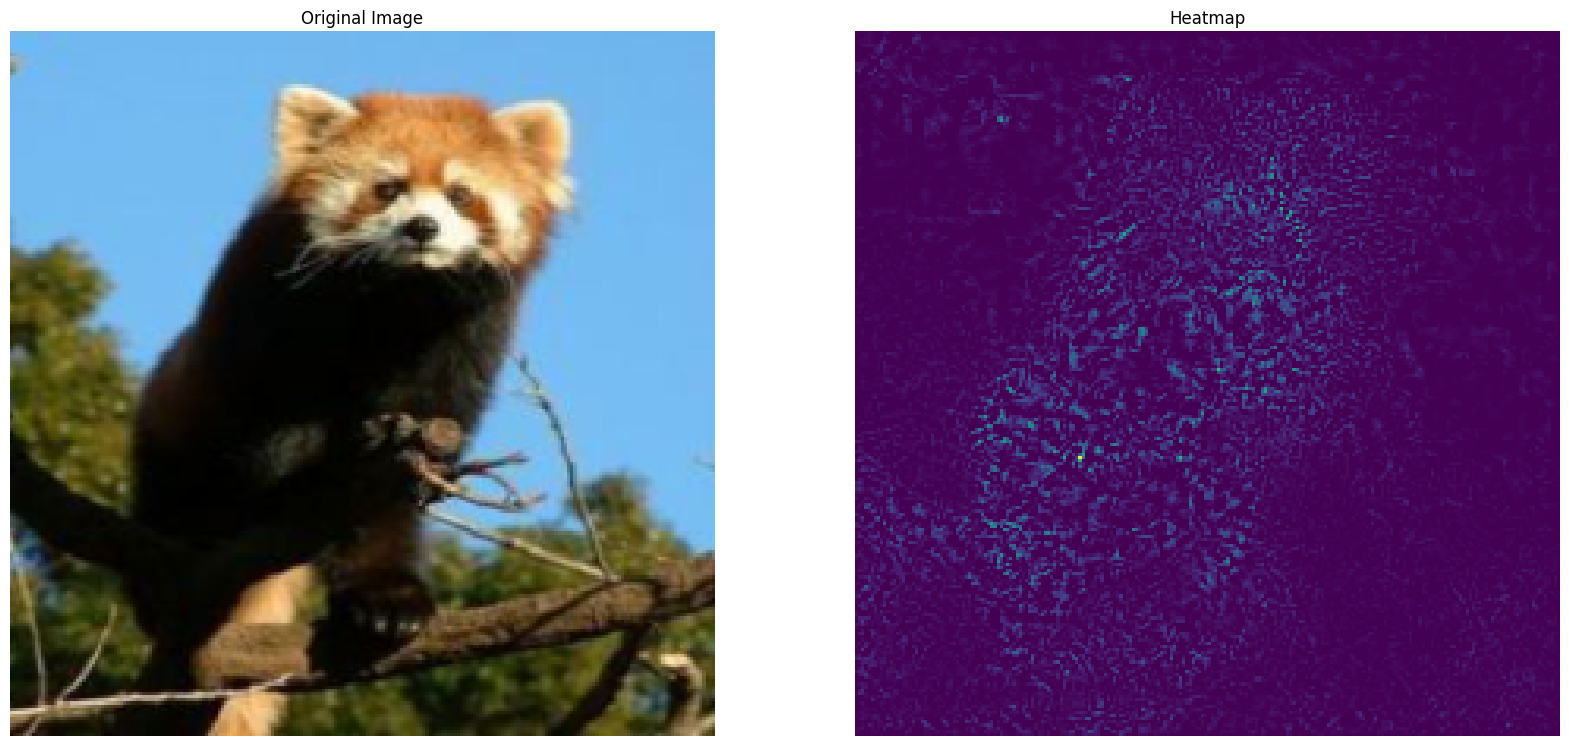

In [ ]:
sample_image= load_image('bhalluk.jpg')

heatmap= saliencyMapFun(sample_image, ind)
# sample_image = image_preprocess_for_sal(sample_image)
# print(heatmap.shape)
plot_image(imgx,heatmap)

207


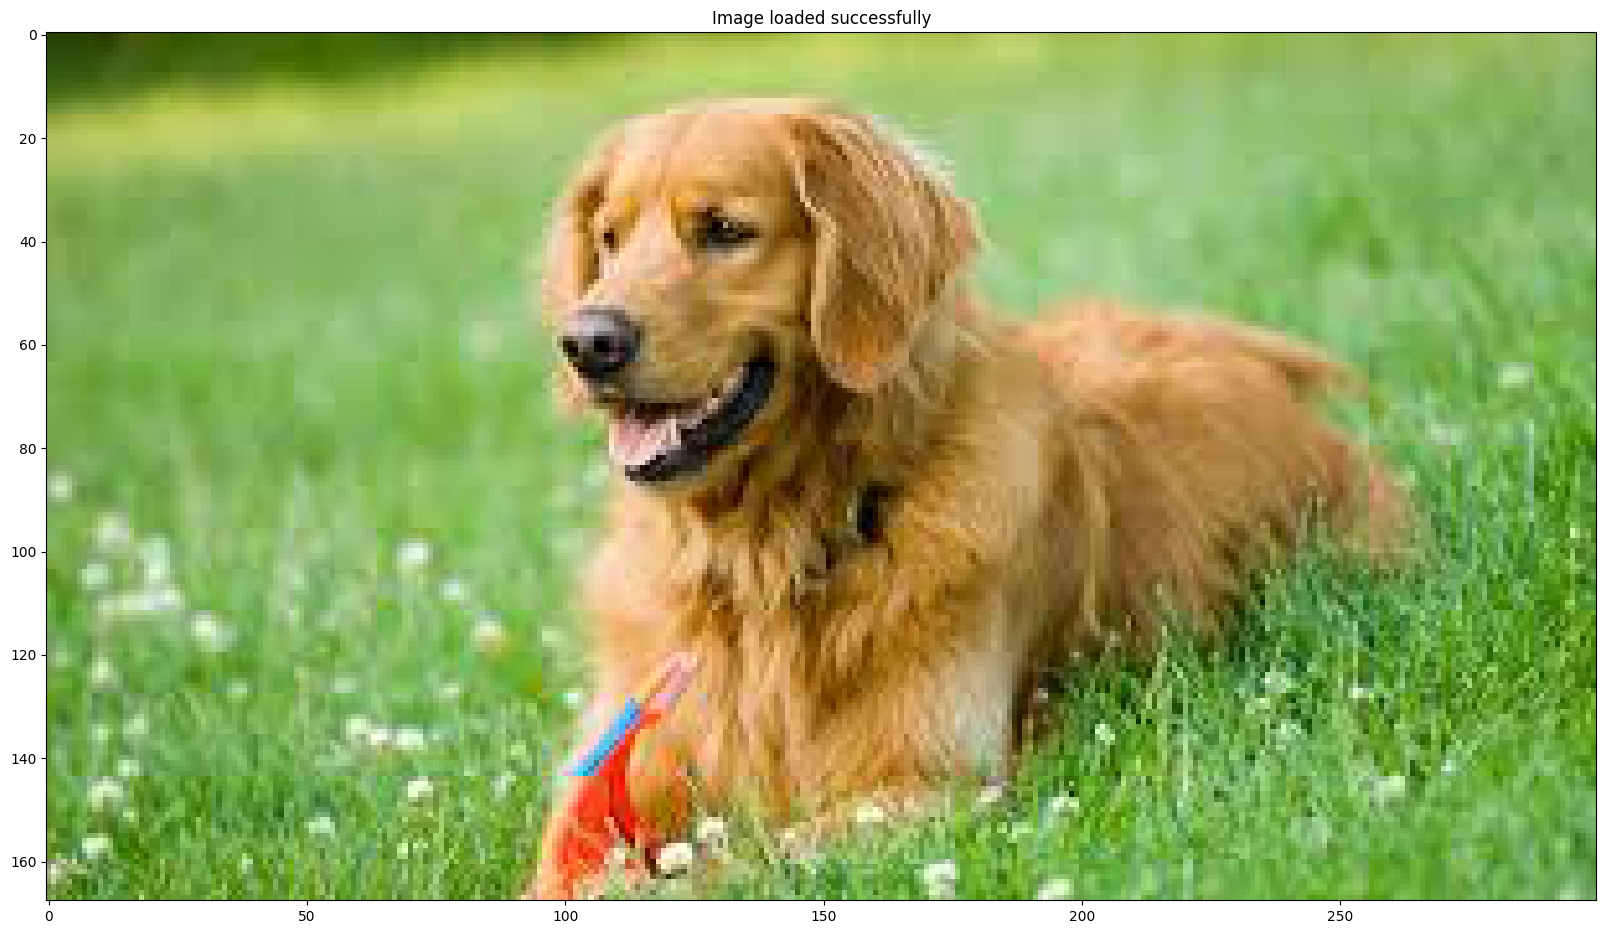

In [23]:
imgx=load_image('retr.jpeg')
imgx=image_preprocess(imgx)

ind,_=predict(imgx)
print(ind)


tensor([[[[-1.4500, -1.4500, -1.4500,  ...,  0.4679,  0.3994,  0.3481],
          [-1.4329, -1.4329, -1.4329,  ...,  0.4679,  0.4166,  0.3652],
          [-1.4329, -1.4329, -1.4329,  ...,  0.4851,  0.4337,  0.3652],
          ...,
          [-0.1657, -0.2171, -0.2856,  ...,  0.1426, -0.2342, -0.3369],
          [-0.1143, -0.2342, -0.3712,  ...,  0.2624, -0.1486, -0.2342],
          [-0.0116, -0.1999, -0.5253,  ...,  0.3309, -0.0972, -0.1657]],

         [[-0.8978, -0.8978, -0.8978,  ...,  1.1681,  1.1331,  1.0980],
          [-0.8803, -0.8803, -0.8803,  ...,  1.1856,  1.1506,  1.1155],
          [-0.8627, -0.8627, -0.8627,  ...,  1.2031,  1.1681,  1.1155],
          ...,
          [ 0.5028,  0.5203,  0.5203,  ...,  1.1856,  0.8354,  0.7479],
          [ 0.6429,  0.5553,  0.5028,  ...,  1.2731,  0.8880,  0.8529],
          [ 0.8004,  0.6254,  0.3978,  ...,  1.3431,  0.9230,  0.9230]],

         [[-1.7696, -1.7870, -1.8044,  ...,  0.0605, -0.0092, -0.0790],
          [-1.7522, -1.7696, -

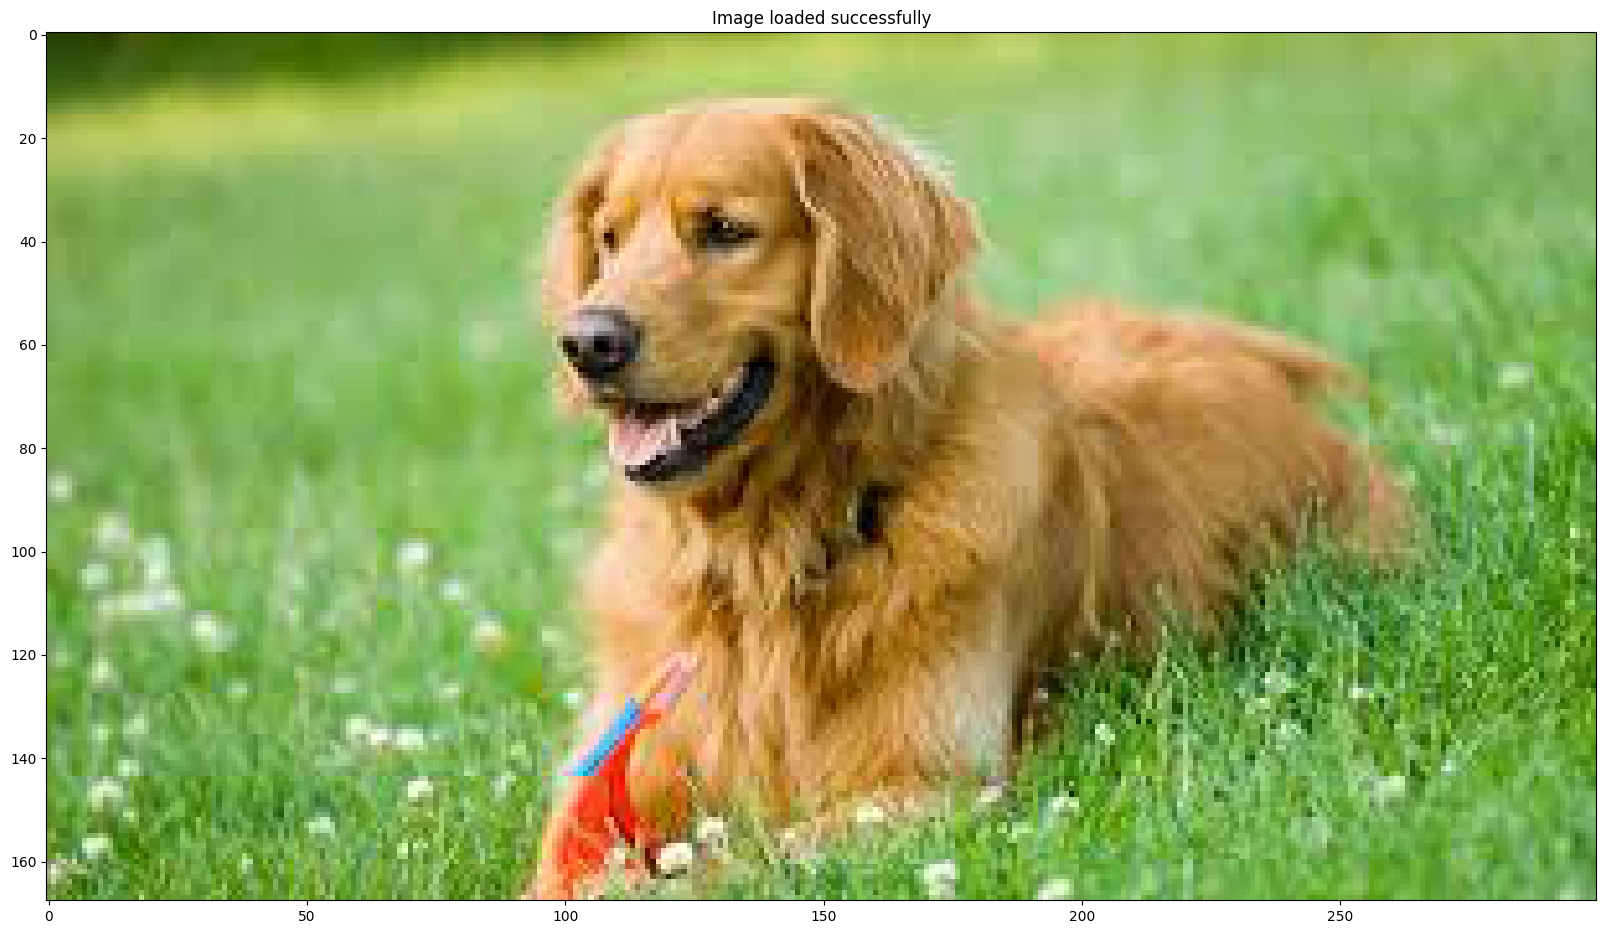

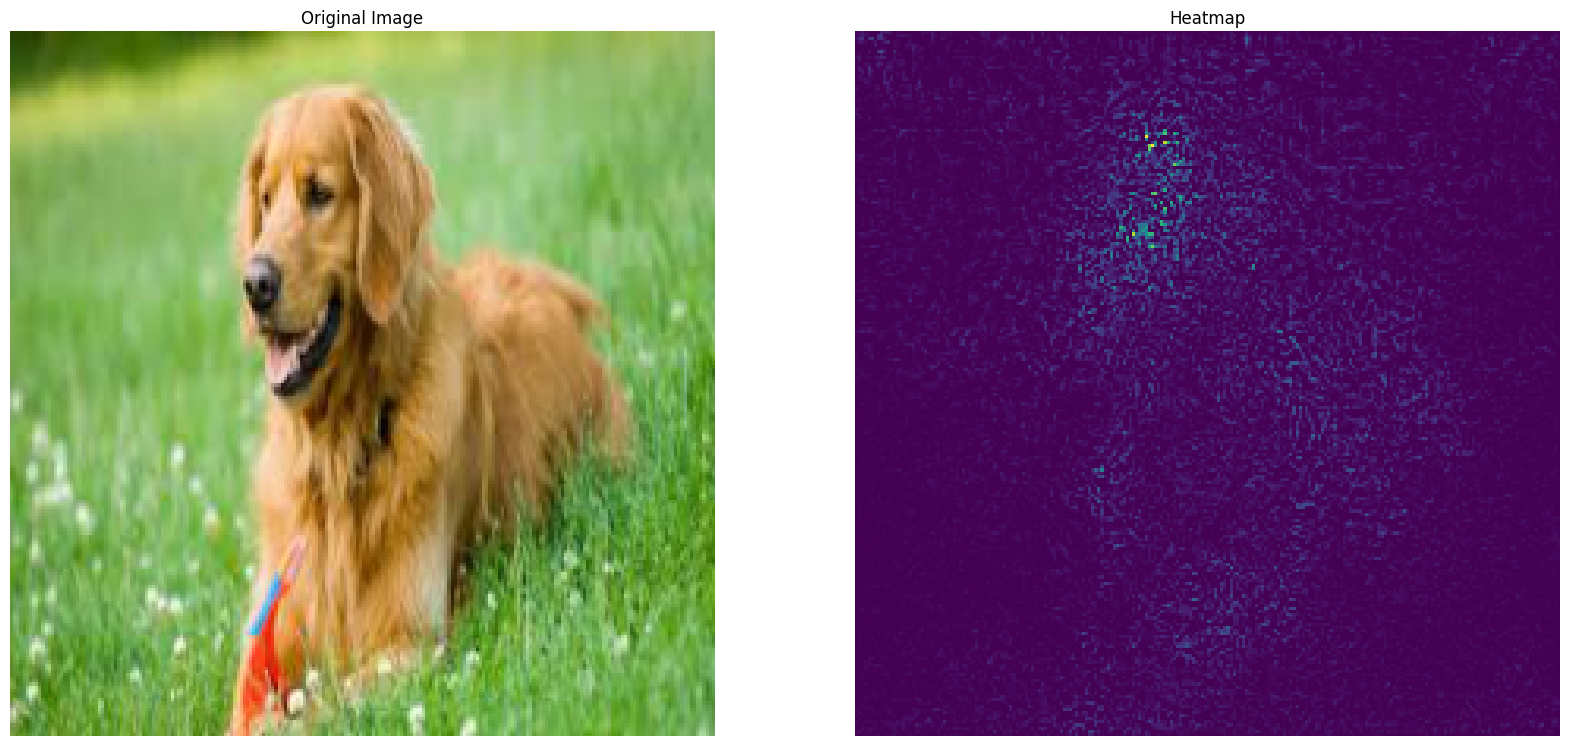

In [24]:
sample_image= load_image('retr.jpeg')

heatmap= saliencyMapFun(sample_image, ind)
# sample_image = image_preprocess_for_sal(sample_image)
# print(heatmap.shape)
plot_image(imgx,heatmap)

In [25]:

def smoothGradient(input, label, x=10, percent_noise=10):
   
    tensor_input = torch.from_numpy(np.array(input)).type(torch.cuda.FloatTensor) # input is now of shape (w,h,c)
    
    z=(tensor_input.max() - tensor_input.min())
    z=z.cpu().detach().numpy()
    i=0
    total_grad = torch.zeros((1,3,224,224)).cuda()
    while i<x:
        t = tensor_input
        noise = torch.from_numpy(np.random.normal(loc=0, scale=(percent_noise/100) * z, size=t.shape)).type(torch.cuda.FloatTensor)
        t = (t + noise)
        t=t.cpu().numpy()
        t = Image.fromarray(t.astype(np.uint8))
        t= Variable(image_preprocess(t).cuda(), requires_grad=True)
        output = vgg.forward(t)
        output[0][label].backward()
        total_grad=total_grad+ t.grad.data
        i=i+1
    
    heatmap =total_grad/x
    heatmap = heatmap.clamp(min=0)
    heatmap.squeeze_()
    heatmap.transpose_(0,1)
    heatmap.transpose_(1,2)
    heatmap= np.amax(heatmap.cpu().numpy(), axis=2)
    return heatmap






def plot_image_with_smooth_grad(image,heatmap):
    
    temp_image = image_preprocess(image)
    updated_image=image_detouch(temp_image)
    updated_image= updated_image.cpu().detach().numpy()
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (20, 20)
    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(updated_image)
    plt.title('Original Image')
    plt.axis('off') 

    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(heatmap)
    plt.title('Heatmap')
    plt.axis('off') 



387


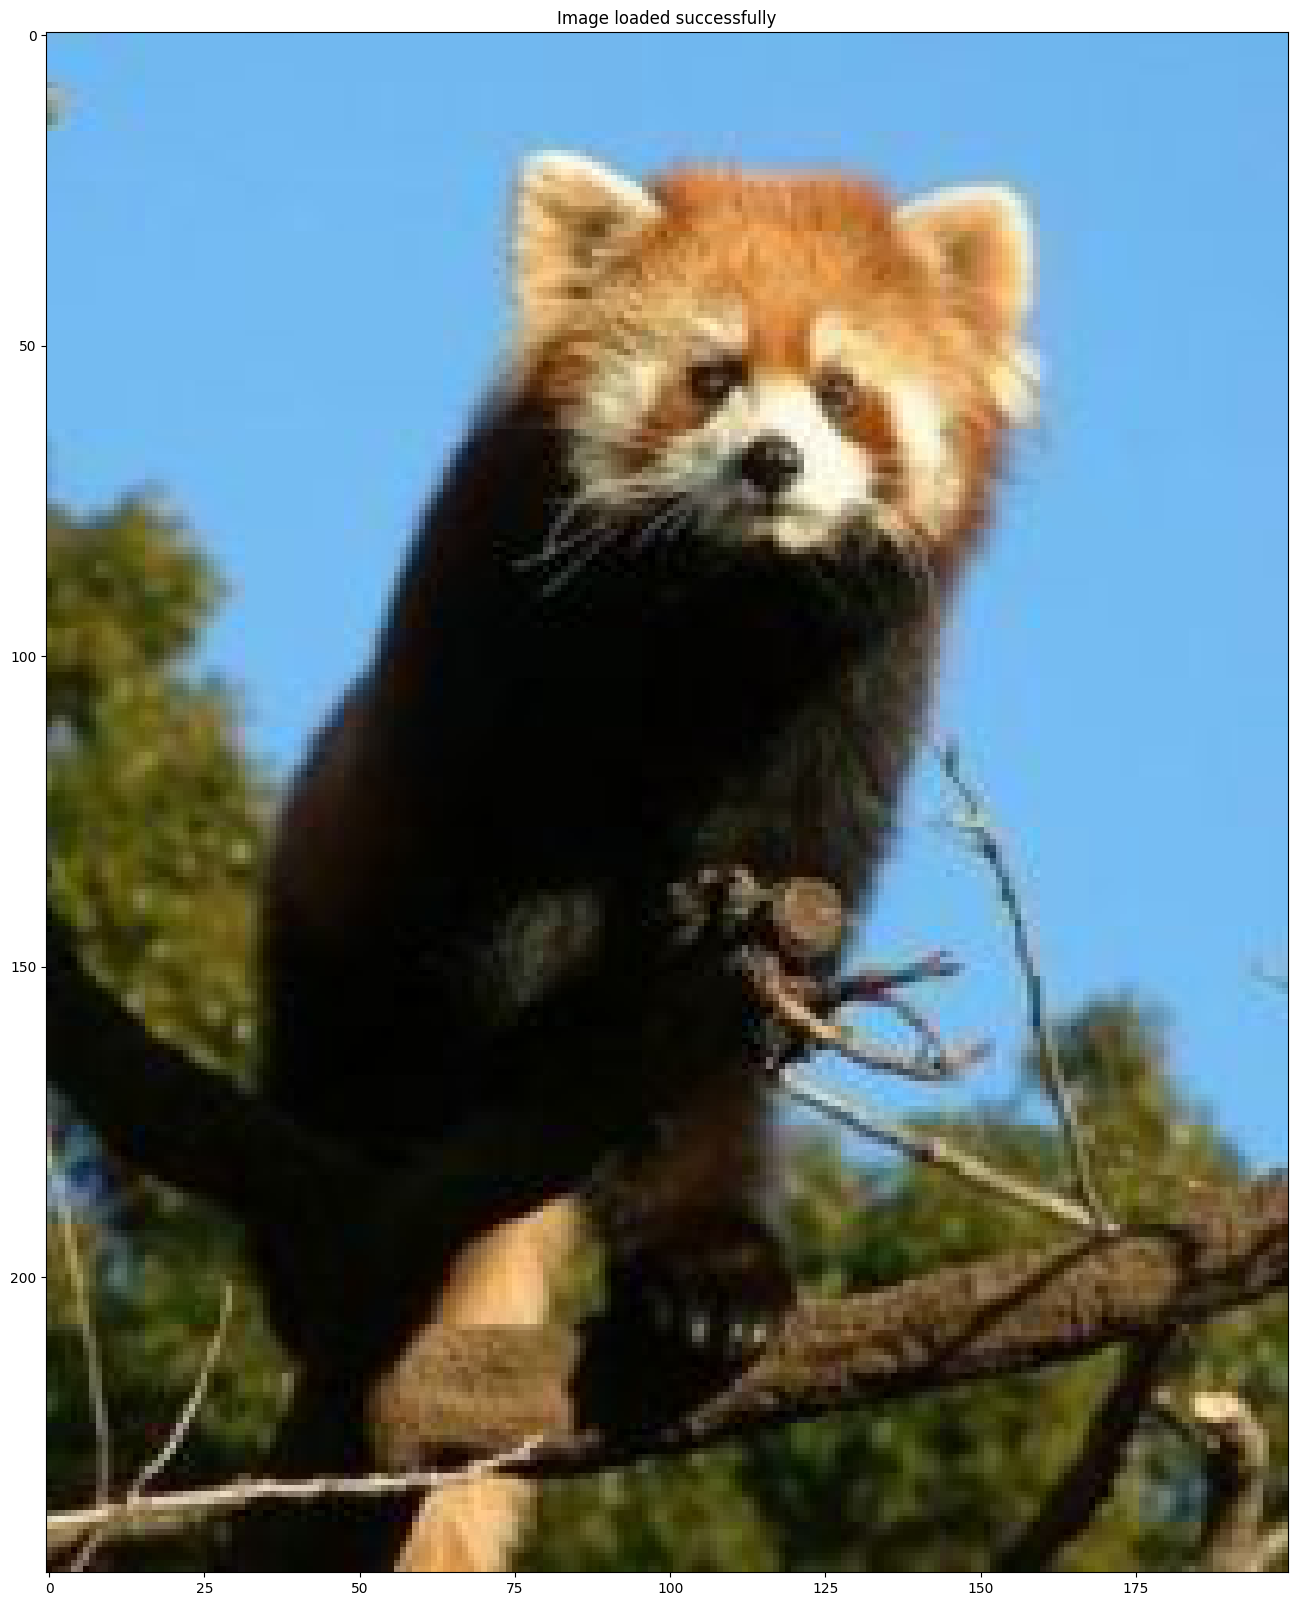

In [26]:
imgx=load_image('bhalluk.jpg')
imgx=image_preprocess(imgx)

ind,_=predict(imgx)
print(ind)


387
checkpoiny


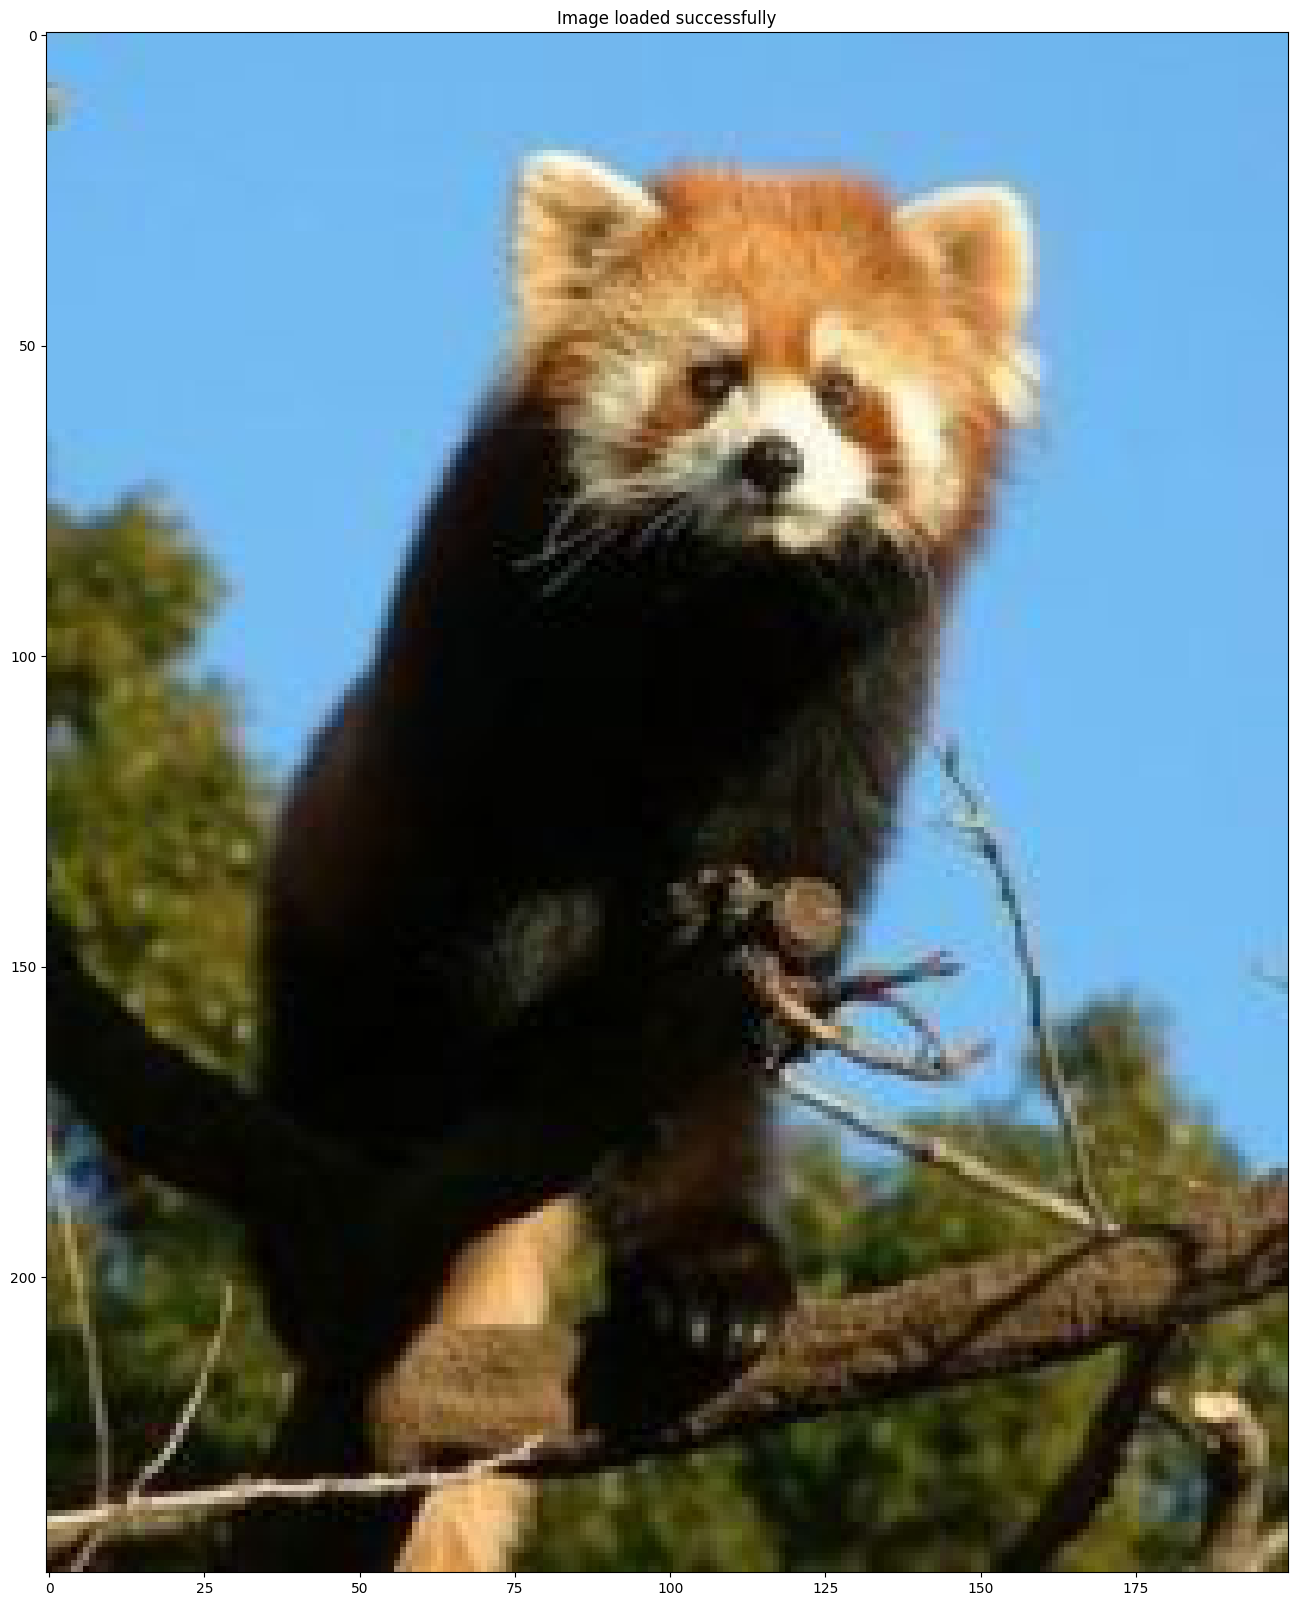

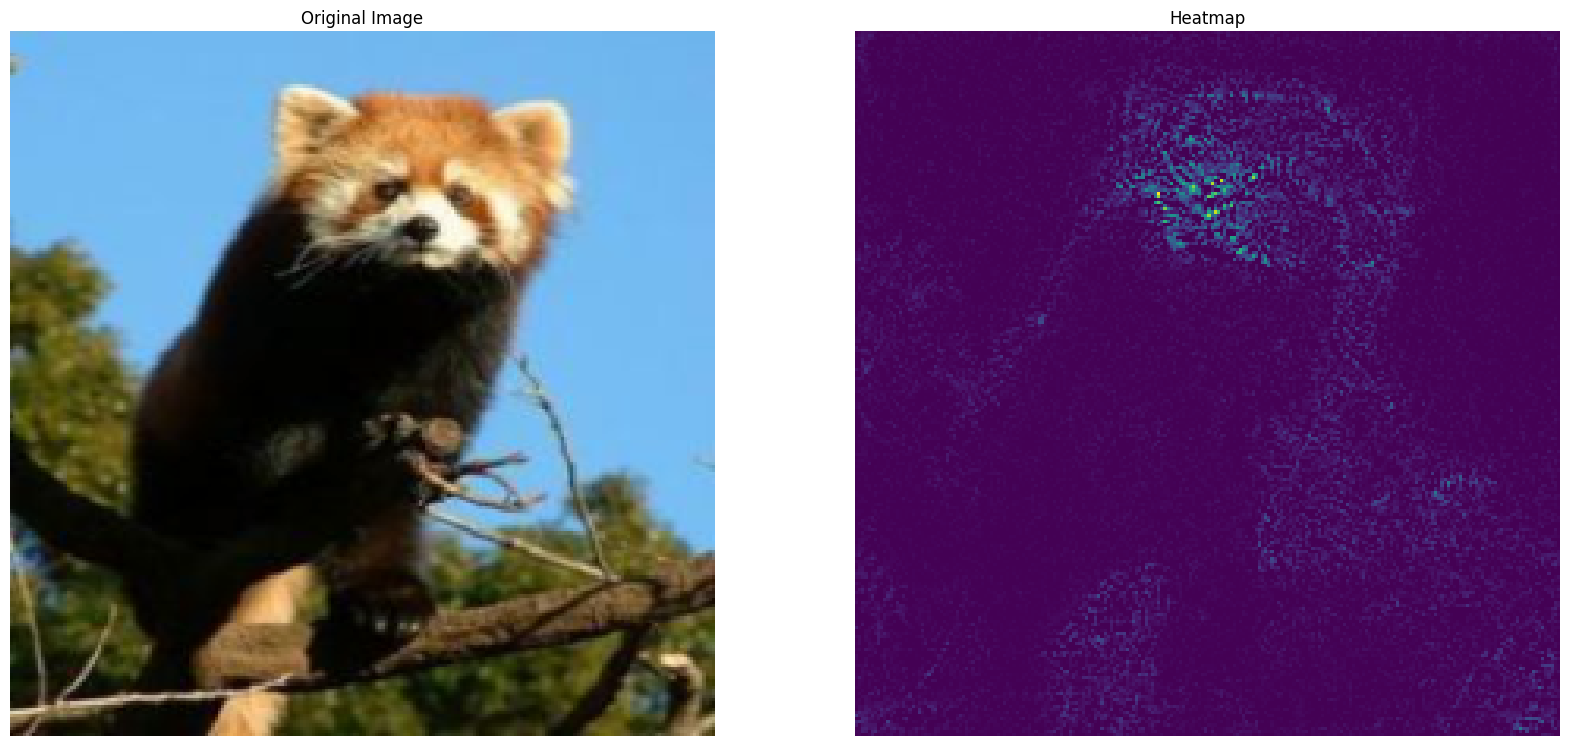

In [27]:


sample_image = load_image('bhalluk.jpg')
print(ind)
heatmap = smoothGradient(sample_image, ind, 30, 10)
plot_image_with_smooth_grad(sample_image,heatmap)

207
207
checkpoiny


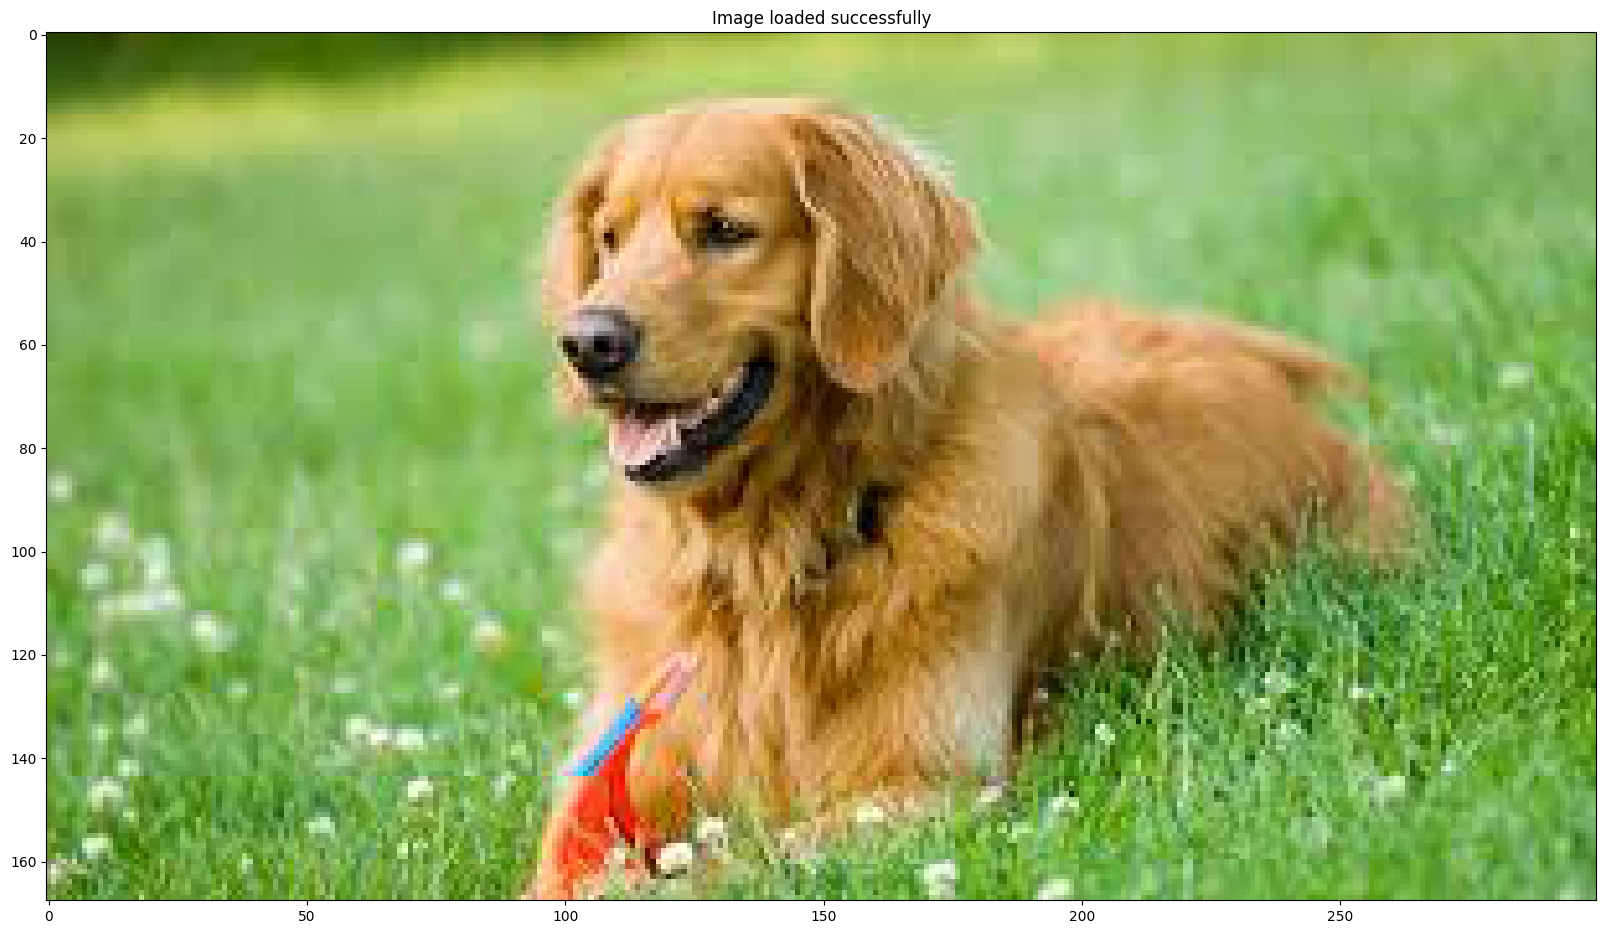

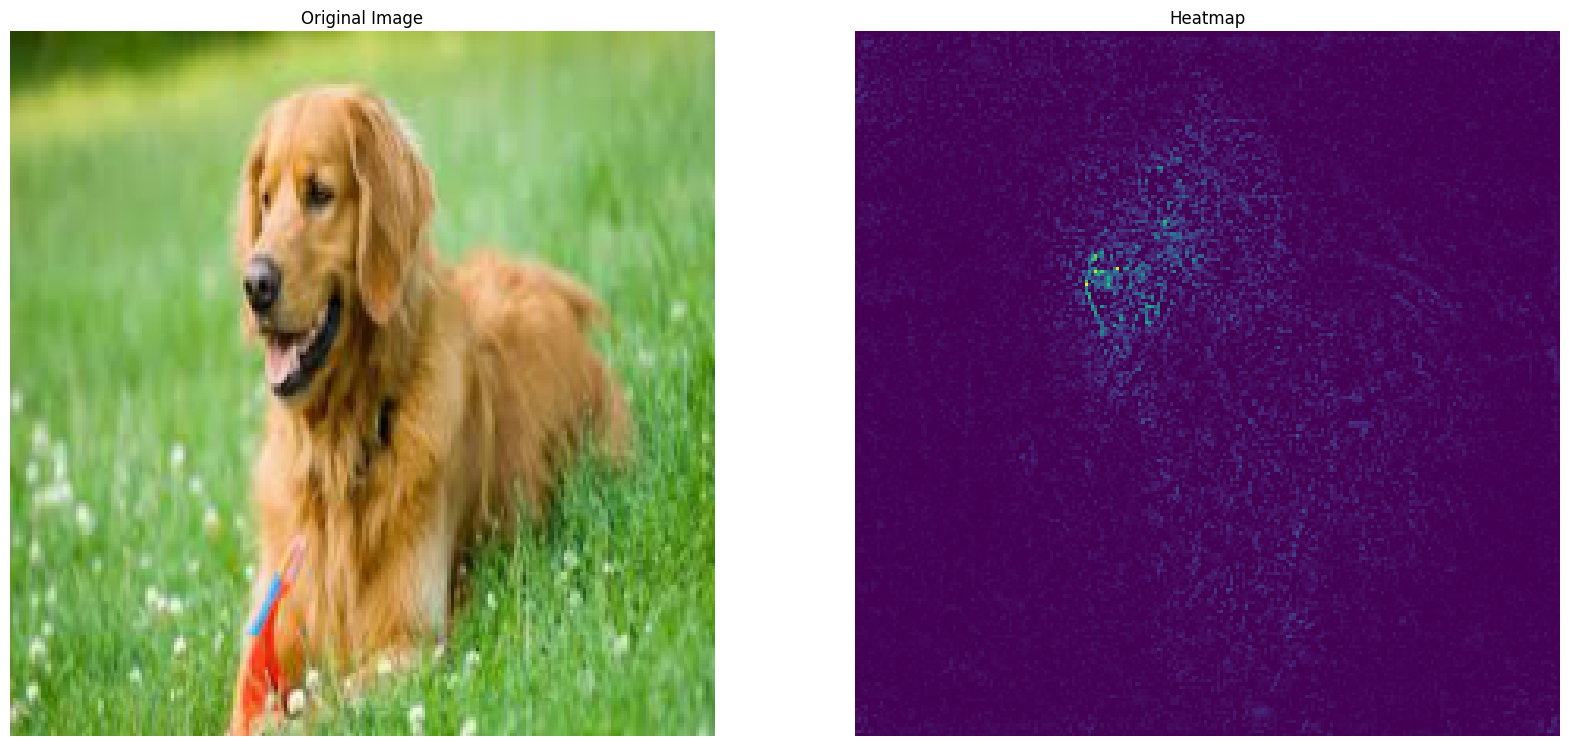

In [28]:
imgx=load_image('retr.jpeg')
imgx=image_preprocess(imgx)

ind,_=predict(imgx)
print(ind)

sample_image = load_image('retr.jpeg')
print(ind)
heatmap = smoothGradient(sample_image, ind, 30, 10)
plot_image_with_smooth_grad(sample_image,heatmap)

In [29]:
def make_class_map(label,cm,mean , l=250, r=1):
    
    cm += mean
    cm = cm.transpose(2,1,0)
    cm = Variable(torch.Tensor(cm).unsqueeze(0).cuda(), requires_grad=True)
    i=0
    while i<1000:
        vgg.zero_grad()
        out = vgg(cm)[0][label] + r * cm.norm()
        out.backward()
        cm.data = cm.data + l * cm.grad.data
        i=i+1
    return cm
def plot_cmap(cm,label):
  cm = cm.data.squeeze()
  cm.transpose_(0,1)
  cm.transpose_(1,2)
  cm= np.clip(np.array(image_deprocess(cm).cpu()),0,255).astype('uint8')
  plt.figure(figsize=(5,5))
  plt.imshow(cm)
  plt.axis('off')

  plt.title(labels[str(label)][1])
    



cmap


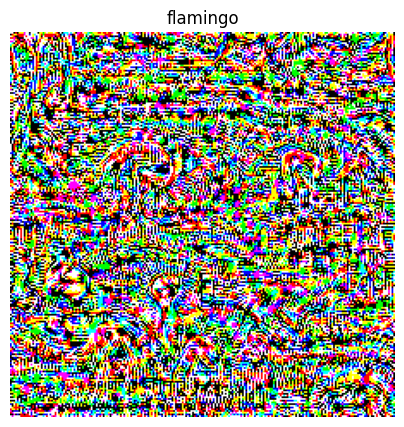

In [30]:
mean = np.array([0.485, 0.456, 0.406])
cm = np.zeros((224,224,3))
flamingo_cmap = make_class_map(130, cm,mean, 300, 0.5)
print("cmap")
plot_cmap(flamingo_cmap,130)

cmap


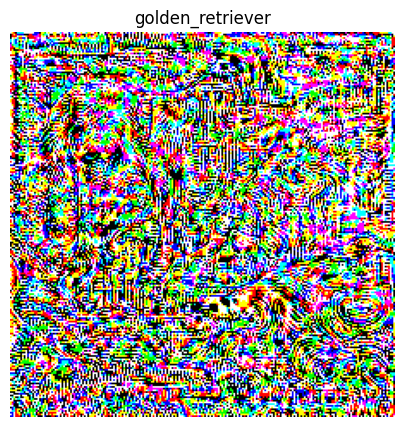

In [32]:
mean = np.array([0.485, 0.456, 0.406])
cm = np.zeros((224,224,3))
flamingo_cmap = make_class_map(207, cm,mean, 300, 0.5)
print("cmap")
plot_cmap(flamingo_cmap,207)

In [36]:

if not os.path.exists('intfolder'):
    os.makedirs('intfolder')
dir='intfolder'
for filename in os.listdir(dir):
    file_path = os.path.join(dir, filename)
    if os.path.isfile(file_path):
        os.remove(file_path)
video_capture = cv2.VideoCapture('animalvideo.mp4')
frame_count = 0
while True:
    ret, frame = video_capture.read()
    if not ret:
        break
    cv2.imwrite(f'intfolder/frame{frame_count}.jpg', frame)
    frame_count += 1
video_capture.release()
cv2.destroyAllWindows()


In [39]:


images=[]
if not os.path.exists('imgfolder'):
    os.makedirs('imgfolder')
dir_path = 'imgfolder'

for filename in os.listdir(dir_path):
    file_path = os.path.join(dir_path, filename)
    if os.path.isfile(file_path):
        os.remove(file_path)

for i in range(frame_count):
  images.append(load_image(f'intfolder/frame{i}.jpg'))
for i in range(frame_count):
  inp_img=images[i]
  imgx=images[i]
  imgx=image_preprocess(imgx)


  ind,_=predict(imgx)
  x= smoothGradient(inp_img, ind, 30, 10)
  outputimg = Image.fromarray(np.uint8(x))
  outputimg.save(f'imgfolder/image{i}.jpg')
  if i%50==0:
    print(i)
  



checkpoiny
0
checkpoiny
checkpoiny
checkpoiny
checkpoiny


KeyboardInterrupt: ignored

Error in callback <function _draw_all_if_interactive at 0x7f9a44635d80> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f9a44635000> (for post_execute):


KeyboardInterrupt: ignored

In [82]:

directory = 'imgfolder'

file_names = os.listdir(directory)


file_numbers = [int(file_name.replace('image', '').replace('.jpg', '')) for file_name in file_names]

image_files= [f'image{file_number}.jpg' for file_number in sorted(file_numbers)]

# Get the dimensions of the first image
first_image = cv2.imread(os.path.join('imgfolder', image_files[0]))
height, width, channels = first_image.shape

# Initialize the video writer object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter('output_video.mp4', fourcc, 30.0, (width, height))

# Write each image to the video file
for image_file in image_files:
    image_path = os.path.join('imgfolder', image_file)
    print(image_path)
    image = cv2.imread(image_path)
    video_writer.write(image)

# Release the video writer object
video_writer.release()


IndexError: ignored